In [1]:
# !pip install --upgrade --force-reinstall --no-deps albumentations
# !pip install qudida
# ! pip install opencv-python-headless==4.1.2.30

# !pip install albumentations==0.4.6
# !pip uninstall albumentations -y & pip install albumentations==0.4.6
# !pip install --upgrade --force-reinstall --no-deps torch torchvision

# !pip freeze | grep opencv

In [2]:
!python --version

Python 3.8.2


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# %matplotlib notebook
# %matplotlib inline 

import glob
import torch
import os, sys
import cv2 as cv
import matplotlib
import torchvision
import numpy as np 
import pandas as pd
import seaborn as sns
import albumentations as A 
import matplotlib.pyplot as plt 
import xml.etree.ElementTree as ET
from matplotlib.patches import Rectangle
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

plt.style.use('dark_background')

A.__version__, torch.__version__, torchvision.__version__

('0.4.6', '1.10.0+cpu', '0.11.1+cpu')

In [5]:
base_path = './'
os.chdir(base_path)
os.getcwd() 

# !unzip "/content/drive/MyDrive/mask_nomask/archive (3).zip" -d {os.path.join(base_path, "datasets")}

'F:\\pyidle\\ml\\mask_nomask_torch\\mask_nomask'

In [6]:
class TrainValidIndex:
    def __init__(self, n_samples, frac, seed):
        np.random.seed(seed)
        idx_range      = np.arange(n_samples)
        valid_samples  = int(n_samples * frac)
        train_samples  = int(n_samples - valid_samples) 
        self.train_idx = np.random.choice(idx_range, train_samples)
        self.valid_idx = [i for i in idx_range if i not in self.train_idx]

class csvDataset(Dataset):
    def __init__(self, base_path, transform = None, subset = 'train', valid_frac = 0.2, channel_after = True, seed = 0):
        self.img_path  = os.path.join(base_path, 'images')
        self.lbl_path  = os.path.join(base_path, 'annotations')
        self.data      = np.array(os.listdir(self.img_path))
        self.subset    = subset
        self.transform = transform 
        self.channel_after = channel_after

        if self.subset != 'test': 
            self.idx  = TrainValidIndex(self.data.shape[0], valid_frac, seed)
            if self.subset == 'train':
                self.data = self.data[self.idx.train_idx] 
            elif self.subset == 'validation':
                self.data = self.data[self.idx.valid_idx]

        self.n_samples = self.data.shape[0]
        
    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
    
        label_enc = {
            'with_mask'             : 1,
            'without_mask'          : 2,
            'mask_weared_incorrect' : 3,
        }

        img_name = self.data[index]
        lbl_name = f"{self.data[index].split('.')[0]}.xml"
        img_path = os.path.join(self.img_path, img_name)
        xml_path = os.path.join(self.lbl_path, lbl_name)

        image    = plt.imread(img_path) # HWC | RGB
        out_channel = image.shape[-1]
        if out_channel == 4:
            image  = np.array(cv.cvtColor(image, cv.COLOR_RGBA2RGB))
        elif out_channel == 1:
            image  = np.array(cv.cvtColor(image, cv.COLOR_GRAY2RGB))

        xmlf     = ET.parse(xml_path).getroot()

        target   =   {
          "image_id"   : torch.tensor([index], dtype = torch.int64),
          "boxes"    : [],
          "area"    : [],
          "labels"   : [],
        }

        for object in xmlf.findall('object'):
            label  = label_enc[object.find('name').text]
            x1, y1, x2, y2  = [int(i.text) for i in object.find('bndbox')]
            area   = (x2 - x1) * (y2 - y1)

            target['boxes'].append([x1, y1, x2, y2])
            target['area'].append(area)
            target['labels'].append(label)
            
        target['boxes']   = torch.tensor(target['boxes'],   dtype = torch.int64)
        target['area']   = torch.tensor(target['area'],   dtype = torch.float32)
        target['labels']  = torch.tensor(target['labels'],  dtype = torch.int64)

        if self.transform:
            image, target = self.transform(image, target, subset = self.subset)

        image = torch.from_numpy(image)
        if not self.channel_after:
            image = image.permute(-1, 0, 1)

        return image, target

In [7]:
# def plot_img_bbox(image, target, channel_after = True):
#   fig, ax = plt.subplots()
#   img = image.detach()
#   if not channel_after:
#     img = img.T
#   ax.imshow(img)

#   label_enc = {
#         1 : ['with_mask', 'red'],
#         2 : ['without_mask', 'blue'],
#         3 : ['mask_weared_incorrect', 'green'],
#     }

#   bboxes = target['boxes']
#   labels = target['labels']
#   for ind, bbox in enumerate(bboxes):
#     w, h = xy_to_wh(bbox)
#     rect = Rectangle((bbox[0], bbox[1]), w, h, linewidth = 1, edgecolor = label_enc[labels[ind].item()][1], facecolor='none')
#     plt.text(bbox[0] + 0.05, bbox[1] + 0.05, label_enc[labels[ind].item()][0], fontsize = 'medium', backgroundcolor = label_enc[labels[ind].item()][1])
#     ax.add_patch(rect)

#   ax.axis(False)
  # plt.show()

In [8]:
def xy_to_wh(bbox):
    x1, y1, x2, y2 = bbox
    w = x2 - x1 
    h = y2 - y1
  
    return w, h

def plot_img_bbox(ax, image, target, channel_after = True, show_labels = True):
    img = image.detach()
    if not channel_after:
        img = img.permute(1, 2, 0)
    ax.imshow(img)

    label_enc = {
        1 : ['with_mask', 'red'],
        2 : ['without_mask', 'blue'],
        3 : ['mask_weared_incorrect', 'green'],
    }

    bboxes = target['boxes']
    labels = target['labels']
    for ind, bbox in enumerate(bboxes):
        w, h = xy_to_wh(bbox)
        rect = Rectangle((bbox[0], bbox[1]), w, h, linewidth = 1, edgecolor = label_enc[labels[ind].item()][1], facecolor='none')
        if show_labels:
            ax.text(bbox[0] + 0.05, bbox[1] + 0.05, label_enc[labels[ind].item()][0], fontsize = 'medium', backgroundcolor = label_enc[labels[ind].item()][1])
        ax.add_patch(rect)
    ax.axis(False);

def get_row(num, col):
    if num % col == 0:
        return num // col
    return (num // col) + 1

def show_img(loader, num, col = 5, channel_after = True, show_labels = True):
    image, target = next(iter(loader))
    num = min(len(image), num)
    row = get_row(num, col)

    fig, ax = plt.subplots(row, col, figsize = (col * 4, row * 4))

    ind = 0
    for i in range(row):
        for j in range(col):
            plot_img_bbox(ax[i, j], image[ind], target[ind], channel_after, show_labels)
            ind += 1


def compute_mean_std(loader, channel_after = True):
    channel_sum, channel_sq_sum, num_batches = 0, 0, 0
    if channel_after:
        dim = [0, 1, 2]
    else:
        dim = [0, 2, 3]

    for x, _ in loader:
        x = torch.stack(x)
        channel_sum    = torch.mean(x, dim = dim)
        channel_sq_sum = torch.mean(x**2, dim = dim)
        num_batches   += 1

    mean = channel_sum / num_batches
    std  = torch.sqrt( channel_sq_sum / num_batches - mean**2 )

    return mean, std


def plot_mean_area(loader):
    areas = []
    for _, y in loader:
        for a in y:
            for i in a['area'].flatten():
                areas.append(i)

    areas = np.array(areas)
    try:
        plt.figure(figsize = (12, 6))
        sns.distplot(areas)
        plt.axvline(areas.mean(), linewidth = 3.5, color = 'red', linestyle = '--')
        plt.title(areas.mean())
        plt.grid(False)
    except:
        print(areas)

In [9]:
MEAN = [0.0090, 0.0080, 0.0076]
STD  = [0.0728, 0.0659, 0.0631]
H, W = (480, 480)

def collate_fn(batch):
    return tuple(zip(*batch))

def alb_transform(image, target, subset):
    min_area       = 0
    min_visibility = 0

    if subset == 'train':
        transform = A.Compose([
                           A.Resize(H, W),
                           A.HorizontalFlip(p = 0.5),
                           A.Rotate(limit = 30, p = 0.3, border_mode = cv.BORDER_CONSTANT),
                           A.CoarseDropout(max_holes = 20, p = 0.5),
                           A.OneOf([
                                    A.GaussianBlur(blur_limit = 5),
                                    A.MedianBlur(blur_limit = 3),
                                    A.Blur(blur_limit = 3)
                           ], p=1),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_area = min_area, min_visibility = min_visibility))
    else:
        transform = A.Compose([
                           A.Resize(H, W),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    transformed = transform(image = image, bboxes = target['boxes'], class_labels = target['labels'])
    image = transformed['image']
    target['boxes'] = torch.tensor(transformed['bboxes'])
    target['labels'] = torch.stack(transformed['class_labels']) if len(transformed['class_labels']) > 0 else torch.tensor(transformed['class_labels'])

    return image, target

In [10]:
base_path = './datasets/' 

dataset   = csvDataset(base_path, alb_transform, 'train', 0.2, 0)
valid_dataset = csvDataset(base_path, alb_transform, 'validation', 0.2, 0)

train_loader = DataLoader(dataset, batch_size = 4, shuffle = True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size = 4, shuffle = False, collate_fn = collate_fn)

len(train_loader), len(valid_loader)

(171, 94)

In [11]:
i, t = next(iter(train_loader))

t[0]

{'image_id': tensor([265]),
 'boxes': tensor([[ 95.6811, 176.4000, 266.3123, 330.0000]], dtype=torch.float64),
 'area': tensor([13696.]),
 'labels': tensor([1])}

In [12]:
## sanity error check, outputs an error log if there's an error in albumentation 

def error_check(loader):
    batch = 0
    ERROR = False

    try:
        for i, t in loader:
            error = False
            for ind, b in enumerate(t):
                box = np.array(b['boxes'])
                if (box < 0).sum() > 0 or (box > W).sum() > 0:
                    print(f'batch : {batch}')
                    print(f'ind   : {ind}')
                    error = True
                    break
            if error:
                ERROR = True
                break
            batch += 1
    except Exception as err:
        print(err)
        ERROR = True

    print()
    if ERROR:
        print(f"There's an error in batch : {batch}")
    else:
        print("There's no error ...")


error_check(train_loader)
error_check(valid_loader)


There's no error ...

There's no error ...


In [37]:
batches = []
zero_bbox = 0

for b_ind, (_, targets) in enumerate(train_loader):
    for ind, t in enumerate(targets):
        if len(t['boxes']) == 0:
            batches.append([b_ind, ind])
            zero_bbox += 1

print(f'Number of images to have zero bbox : {zero_bbox}') 

Number of images to have zero bbox : 65


In [57]:
# batch_to_get = 3
# for b, (bi,bt) in enumerate(train_loader):
#   if b == batch_to_get:
#     break

# for ind, t in enumerate(bt):
#   if len(t['boxes']) == 0:
#     print(ind)
#     print(t)
#     break

In [ ]:
## error checking on specified batch from the above code 

# batch = 4
# ind = 5
# num = batch * 16 + ind

# dataset[num][1]

# plt.imshow(dataset[num][0].permute(1, 2, 0))

In [ ]:
mean, std = compute_mean_std(train_loader, channel_after = False)
print(f'mean : {mean}')
print(f'std  : {std}')

mean : tensor([0.0090, 0.0080, 0.0076])
std  : tensor([0.0728, 0.0659, 0.0631])


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


CPU times: user 29.5 s, sys: 452 ms, total: 30 s
Wall time: 27 s


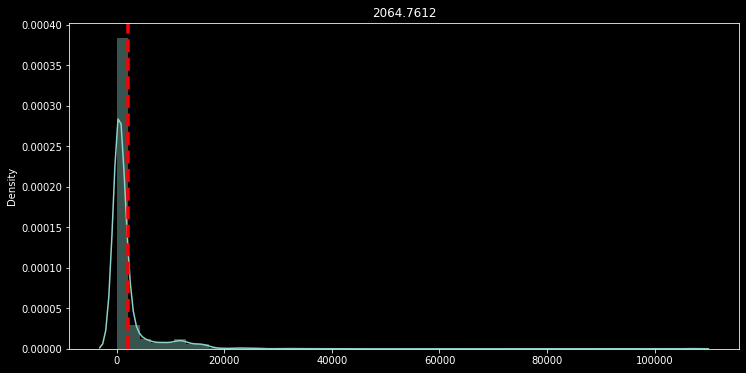

In [ ]:
%%time
plot_mean_area(train_loader)

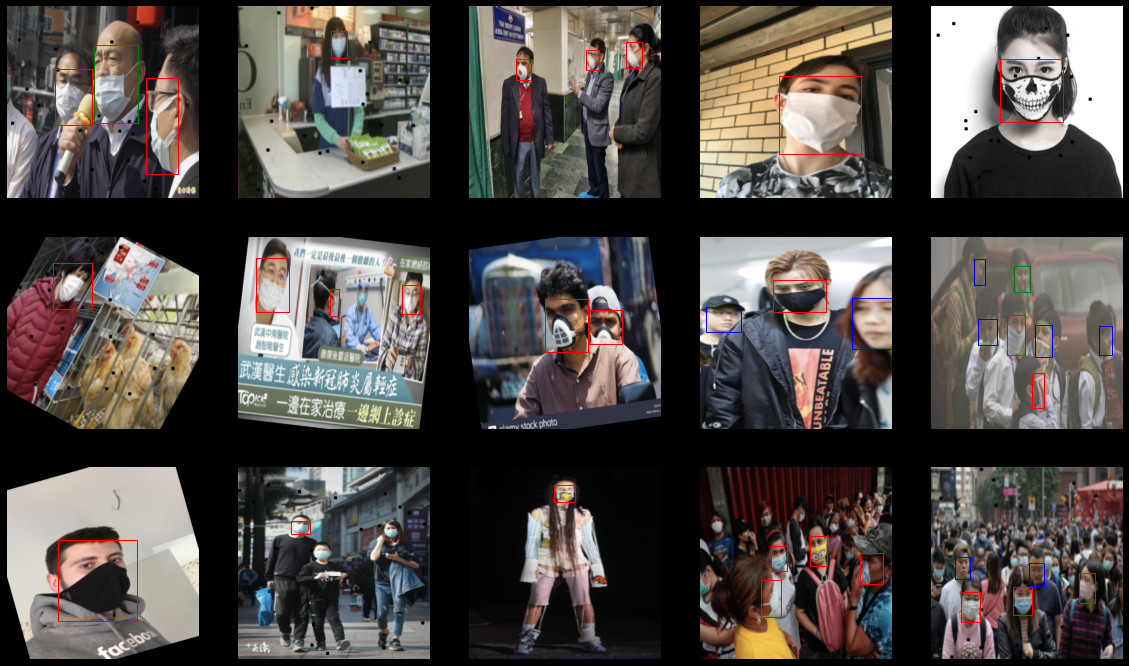

In [25]:
show_img(train_loader, 15, 5, False, show_labels = False)

In [12]:
from torchvision.models import detection 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm 
import json 
import gc

In [13]:
class SAVE_MODEL:
    def __init__(self, filename = 'best_model.pth', base_path = './'):
        self.best_loss = np.inf
        self.filename  = os.path.join(base_path, filename)
  
    def update_loss(self, loss):
        if loss < self.best_loss:
            self.best_loss = loss

    def save_state(self, curr_loss, model, optimizer = None, kwargs = {}):
        if curr_loss < self.best_loss:
            print(f'Loss improved from {self.best_loss} to {curr_loss}, saving the model to {self.filename} ...')

            checkpoint = {
              'loss'            : curr_loss,
              'model_state'     : model.state_dict(),
              'optimizer_state' : optimizer.state_dict(),
              **kwargs
          }

            self.update_loss(curr_loss)
            torch.save(checkpoint, self.filename)
        else:
            print(f'Loss : {curr_loss} did not improve from the best loss : {self.best_loss} ...')

def custom_model(num_classes):
    model = detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    print(f'Box predictor in_features  : {in_features}')
    print(f'Box predictor out_features : {num_classes}')
  
    return model

def validate_model(MODEL, valid_loader, device):
    MODEL.to(device)
    losses = []

    with torch.no_grad():
        for images, targets in valid_loader:
            images = list(img.to(device) for img in images)
            targets = [{k : v.to(device) for k,v in t.items()} for t in targets] 

            loss_dict = MODEL(images, targets)
            loss      = sum(l for l in loss_dict.values())
            loss_val  = loss.item()
            losses.append(loss_val)

    return np.mean(losses) 

def train_one_epoch(MODEL, train_loader, optimizer, device, epoch_num = None, sanity_check = False, valid_loader = None):
    losses = []
    iterr  = -1
    prog_bar = tqdm(train_loader, total = len(train_loader), desc = None if epoch_num == [] else f'Epoch : {epoch_num[0]} / {epoch_num[1]}')
    for images, targets in prog_bar:

        images    = list(img.to(device) for img in images)
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = MODEL(images, targets)
        loss      = sum(l for l in loss_dict.values())
        loss_val  = loss.item()
        losses.append(loss_val)

        prog_bar.set_postfix(Loss = round(np.mean(losses), 4))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if sanity_check:
            break

    vloss = 0.0
    if valid_loader:
        vloss = validate_model(MODEL, valid_loader, device)
        print()
        print(f'Validation Loss :==> {vloss}')
        print()
  
    print()
    print(' Final Batch Losses '.center(60, '='))
    print()
    print(json.dumps({k:v.item() for k, v in loss_dict.items()}, indent = 1))
    print()

    clean_gpu()
    return MODEL, np.mean(losses), vloss

def train_model(MODEL, train_loader, optimizer, epochs, learning_rate = 1e-02, validation_data = None, print_at = 1, device = 'cuda', save_model = None, sanity_check = False):
    device = torch.device(device)
    print(f'DEVICE : {device}')
    MODEL.train()
    MODEL = MODEL.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optimizer(params, lr = learning_rate, weight_decay=0.0005)

    history = {
      'loss' : [],
      'val_loss' : []
  }

    for epoch in range(epochs):
        MODEL, loss, vloss = train_one_epoch(MODEL, train_loader, optimizer, device, [epoch + 1, epochs], sanity_check, valid_loader = validation_data)
        history['loss'].append(loss)
        history['val_loss'].append(vloss)

        if save_model:
            save_model.save_state(round(loss, 4), MODEL, optimizer, {'epoch' : epoch})
    
    return MODEL, history

def clean_gpu():
    gc.collect()
    torch.cuda.empty_cache()

In [14]:
clean_gpu()

In [67]:
model = custom_model(3 + 1)
model.transform.image_mean = MEAN
model.transform.image_std  = STD

model

Box predictor in_features  : 1024
Box predictor out_features : 4


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.009, 0.008, 0.0076], std=[0.0728, 0.0659, 0.0631])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): R

In [68]:
## sanity checking to see whether the model is working properly

optimizer     = torch.optim.SGD 
learning_rate = 1e-2
epochs        = 5
save_model    = SAVE_MODEL()

model, his = train_model(model, train_loader, optimizer, epochs, learning_rate, save_model = save_model, sanity_check = False, validation_data = valid_loader)

DEVICE : cuda


Epoch : 1 / 5: 100%|██████████| 171/171 [05:46<00:00,  2.02s/it, Loss=0.611]



Validation Loss :==> 0.46962814553569027


==================== Final Batch Losses ====================

{
 "loss_classifier": 0.15469716489315033,
 "loss_box_reg": 0.18106383085250854,
 "loss_objectness": 0.019209198653697968,
 "loss_rpn_box_reg": 0.011404518178377971
}

Loss improved from inf to 0.6105, saving the model to ./best_model.pth ...


Epoch : 2 / 5: 100%|██████████| 171/171 [05:46<00:00,  2.03s/it, Loss=0.442]



Validation Loss :==> 0.39697864615366657


==================== Final Batch Losses ====================

{
 "loss_classifier": 0.13158179819583893,
 "loss_box_reg": 0.26999330520629883,
 "loss_objectness": 0.013145486824214458,
 "loss_rpn_box_reg": 0.023010629431142977
}

Loss improved from 0.6105 to 0.4415, saving the model to ./best_model.pth ...


Epoch : 3 / 5: 100%|██████████| 171/171 [05:46<00:00,  2.03s/it, Loss=0.385]



Validation Loss :==> 0.3783091580476245


==================== Final Batch Losses ====================

{
 "loss_classifier": 0.19641174376010895,
 "loss_box_reg": 0.2682570815086365,
 "loss_objectness": 0.02025052160024643,
 "loss_rpn_box_reg": 0.013926563933059447
}

Loss improved from 0.4415 to 0.3846, saving the model to ./best_model.pth ...


Epoch : 4 / 5: 100%|██████████| 171/171 [05:45<00:00,  2.02s/it, Loss=0.36]



Validation Loss :==> 0.40059694922682587


==================== Final Batch Losses ====================

{
 "loss_classifier": 0.29856088757514954,
 "loss_box_reg": 0.3854885697364807,
 "loss_objectness": 0.05285853147506714,
 "loss_rpn_box_reg": 0.046382162701732246
}

Loss improved from 0.3846 to 0.3603, saving the model to ./best_model.pth ...


Epoch : 5 / 5: 100%|██████████| 171/171 [05:45<00:00,  2.02s/it, Loss=0.338]



Validation Loss :==> 0.34855533285431617


==================== Final Batch Losses ====================

{
 "loss_classifier": 0.08474334329366684,
 "loss_box_reg": 0.1955554187297821,
 "loss_objectness": 0.01336895115673542,
 "loss_rpn_box_reg": 0.00498475601778035
}

Loss improved from 0.3603 to 0.3382, saving the model to ./best_model.pth ...


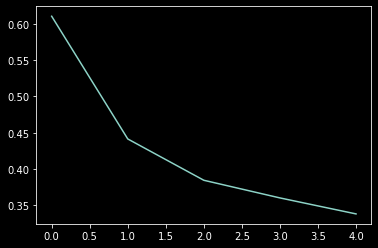

In [71]:
plt.plot(his['losses'])

In [14]:
## post-processing

def apply_nms(orig_prediction, iou_thresh=0.3):
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
  
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
  
    return final_prediction

def predict_images(MODEL, test_loader, device, iou_threshold):
    MODEL.eval()
    MODEL.to(device)

    predictions = []
    with torch.no_grad():
        for test_images, _ in test_loader:
            images  = list(img.to(device) for img in test_images)

            prediction  = MODEL(images)
            prediction  = [{k : v.to(torch.device('cpu')) for k, v in apply_nms(pred_dict, iou_threshold).items()} 
                                                                                   for pred_dict in prediction]
            predictions += prediction

    return predictions

def filter_predictions(predictions, score_threshold):
    filtered_predictions = []
    for pred_dict in predictions:
        scores = pred_dict['scores']
        idx = []
        for ind, score in enumerate(scores):
            if score >= score_threshold:
                idx.append(ind)
                
        pred_dict['boxes'] = pred_dict['boxes'][idx, :]
        pred_dict['labels'] = pred_dict['labels'][idx]
        pred_dict['scores'] = pred_dict['scores'][idx]
        
        filtered_predictions.append(pred_dict)
        
    return filtered_predictions

def pred_show_bbox(MODEL, test_loader, device, iou_threshold, 
                       score_threshold, col = 5, channel_after = False, show_labels = True):
    
    predictions = predict_images(MODEL, test_loader, device, iou_threshold)
    predictions = filter_predictions(predictions, score_threshold)
    images      = []
    for imgs, _ in test_loader:
        images += imgs
    num         = len(images)
    row = get_row(num, col)

    fig, ax = plt.subplots(row, col, figsize = (col * 4, row * 4))

    ind   = 0
    for i in range(row):
        for j in range(col):
            if row == 1:
                axes = ax[j]
            else:
                axes = ax[i, j] 
                
            plot_img_bbox(axes, images[ind], predictions[ind], channel_after, show_labels)
            ind += 1

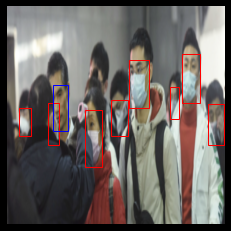

In [16]:
i, t = next(iter(valid_loader))
ind  = 0 
fig, ax = plt.subplots()
plot_img_bbox(ax, i[ind], t[ind], False, False)

In [15]:
def load_model_optimizer(path, device, return_optimizer = True):
    checkpoint = torch.load(path, map_location = device)
    model = custom_model(3 + 1)
    
    learning_rate = 1e-2
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr = learning_rate, weight_decay=0.0005)
    
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    
    for key in checkpoint.keys():
        if 'state' not in key:
            print(f'Best {key} :===> {checkpoint[key]}')
            
    if return_optimizer:
        return model, optimizer
    return model 

Box predictor in_features  : 1024
Box predictor out_features : 4
Best loss :===> 0.3382
Best epoch :===> 4


F:\pyidle\ml\mask_nomask_torch\mask_nomask\venv\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


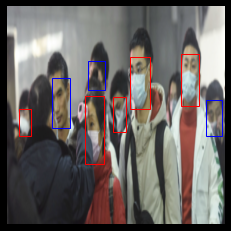

In [17]:
device = torch.device('cpu')
model = load_model_optimizer('best_model.pth', device, False)
model.eval()
model.to(device)
with torch.no_grad():
    pred = model([i[ind].to(device)])

fig, ax = plt.subplots()

det = { k : v.to(device) for k,v in apply_nms(pred[0], 0.1).items()}
plot_img_bbox(ax, i[ind], det, False, False)

In [18]:
apply_nms(pred[0], 0.1)

{'boxes': tensor([[270.0408, 110.9229, 315.6011, 225.0832],
         [382.5355, 104.3228, 423.7474, 218.8542],
         [ 97.8423, 158.2485, 139.1860, 268.3062],
         [177.1760, 119.4604, 214.5578, 183.0748],
         [ 25.1168, 226.2891,  51.0990, 285.0161],
         [232.9802, 200.1289, 260.8869, 275.9946],
         [171.9143, 198.0085, 212.4625, 346.9943],
         [439.4488, 206.1780, 472.5711, 284.6433]]),
 'labels': tensor([1, 1, 2, 2, 1, 1, 1, 2]),
 'scores': tensor([0.9714, 0.8220, 0.7213, 0.3412, 0.3280, 0.1991, 0.0734, 0.0696])}

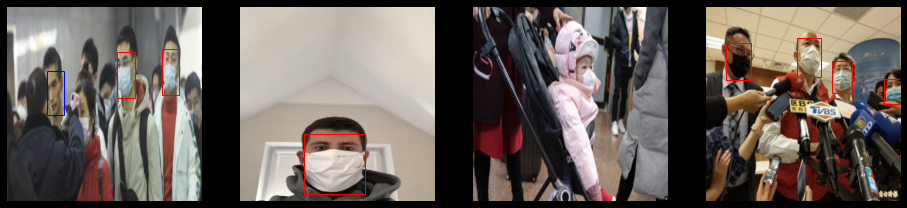

In [45]:
iou_threshold = 0.2
score_threshold = 0.70
col = 4
channel_after = False
show_labels = False

pred_show_bbox(model, [next(iter(valid_loader))], device, iou_threshold, 
                                       score_threshold, col, channel_after, show_labels)

In [22]:
## live webcam demo

from time import sleep 


def close_cam(cap):
    cap.release()
    cv.destroyAllWindows()

H, W = (480, 480)
device = torch.device('cpu')
model = load_model_optimizer('best_model.pth', device, False)

iou_threshold = 0.1
score_threshold = 0.75

cap = cv.VideoCapture(0)
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened():
    ret, frame = cap.read()
    orig_img = np.array(frame)
    img_resized = np.array(cv.resize(orig_img, H, W))
    
    img_tensor = torch.from_numpy(img_resized).permute(-1, 0, 1)
    img_tensor = (img_tensor / 255)
    loader     = [[img_tensor, None]]
    
    predictions  = predict_images(model, loader, device, iou_threshold)
    fpredictions = filter_predictions(predictions, score_threshold)
        
    close_cam(cap)
    break
    
#     if cv.waitKey(10) & 0xFF == ord('q'):
#         close_cam(cap)
#         break

Box predictor in_features  : 1024
Box predictor out_features : 4
Best loss :===> 0.3382
Best epoch :===> 4


error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Input argument doesn't provide sequence protocol
>  - Can't parse 'dsize'. Input argument doesn't provide sequence protocol


In [32]:
cv

<module 'cv2' from 'F:\\pyidle\\ml\\mask_nomask_torch\\mask_nomask\\venv\\lib\\site-packages\\cv2\\__init__.py'>

In [29]:
torch.unsqueeze(torch.tensor([1,2,3]), dim = 0)

tensor([[1, 2, 3]])